In [3]:
# system information
import os
from glob import glob

# computing 
import numpy as np
import pandas as pd
from datetime import datetime
import scipy as sp
import scipy.optimize as op
import statistics 
import seaborn as sns
from random import uniform, seed, random
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
%matplotlib inline

# ROOT files handling
from coffea.nanoevents import NanoEventsFactory, BaseSchema

In [134]:
# define ticks

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

# define ticks
def set_ticks(ax, xMaj, yMaj):
    ax.xaxis.set_major_locator(MultipleLocator(xMaj))
    ax.yaxis.set_major_locator(MultipleLocator(yMaj))
    ax.minorticks_on()
    ax.tick_params(which='major', width=1.0, length=8, direction='in', labelsize=14)
    ax.tick_params(which='minor', width=1.0, length=4, direction='in', labelsize=14)
    ax.yaxis.get_offset_text().set_fontsize(14)
    ax.xaxis.get_offset_text().set_fontsize(14)

In [5]:
params = np.array([0.02588903364201166, 0.0117937685867166])
cov_matrix = np.array([[ 4.25606075e-05, -4.81971726e-08],[-4.81971726e-08,  8.43411455e-11]])

a, b = params[0], params[1]
err_a, err_b = np.sqrt(cov_matrix[0,0]), np.sqrt(cov_matrix[1,1])
cov_ab = cov_matrix[0,1]


def propagate_err(x, sigma_x, a, b, cov_matrix):
    '''
        Propagate error considering TAC cal.
        input:  * x values in ADC
                * sigma_x in ADC
                * calibration parameters a,b 
                * covariance matrix 
        output: uncertainty on y values in us
    '''

    err_a, err_b = np.sqrt(cov_matrix[0,0]), np.sqrt(cov_matrix[1,1])
    cov_ab = cov_matrix[0,1]
    var_y = err_a**2 + err_b**2 * x**2 + 2 * cov_ab * x + b**2 * sigma_x**2
    return np.sqrt(var_y)

def ToADC(t, a, b):
    '''
        Function to convert time in us to ADC
    '''
    adc = (t - a)/ b
    return adc

def ToTime(adc, a, b):
    '''
        Function to convert time in ADC to us
    '''
    y = a + b * adc
    return y

In [6]:
## ---- Constants ---- ##
tau_short = 0.8466      # [us]
tau_long = 2.1969811    # [us]

tau_s_adc = ToADC(0.8466, a, b)
tau_l_adc = ToADC(2.1969811, a, b)

print("tau_short in ADC: %1.1f \ntau_long in ADC: %1.1f"%(tau_s_adc,tau_l_adc))

tau_short in ADC: 69.6 
tau_long in ADC: 184.1


In [143]:
tree = NanoEventsFactory.from_root('root_files/exp_base_v2.root', schemaclass = BaseSchema, treepath='baseline_exp_4').events()
tree2 = NanoEventsFactory.from_root('root_files/exp_base_v2_2.root', schemaclass = BaseSchema, treepath='baseline_exp_4').events()
tree3 = NanoEventsFactory.from_root('root_files/exp_base_v2_3.root', schemaclass = BaseSchema, treepath='baseline_exp_4').events()
tree4 = NanoEventsFactory.from_root('root_files/exp_base_v2_4.root', schemaclass = BaseSchema, treepath='baseline_exp_4').events()

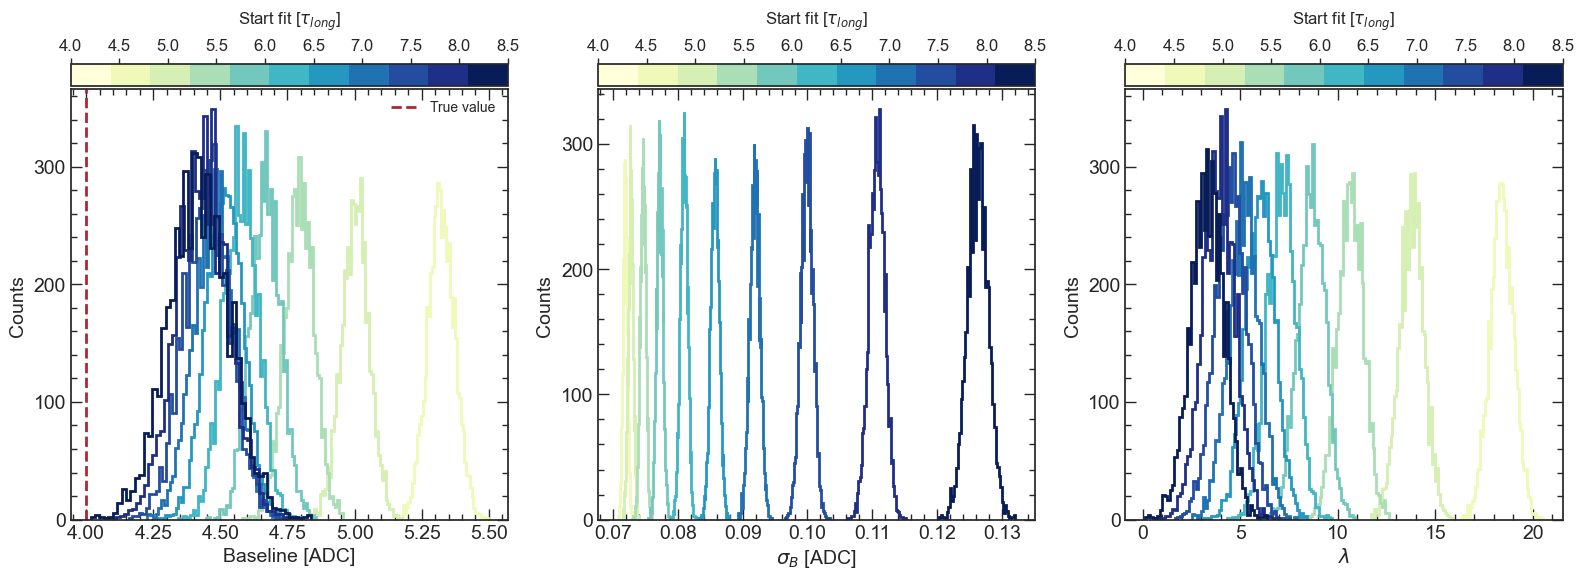

In [161]:
fig, ax = plt.subplots(1, 3, figsize = (16,6))


import matplotlib as mpl

c = np.arange(4,9,0.5)

for k in range(0,3):
    cmap = mpl.cm.get_cmap('YlGnBu',11)
    # Make dummie mappable
    dummie_cax = ax[k].scatter(c, c, c=c, cmap=cmap)
    # Clear axis
    ax[k].cla()  
    for i in range(0,10): 
        if k == 0: ax[k].hist(tree.bs_LL[:,i]/6.0290323, bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(1+i))
        if k == 1: ax[k].hist(tree.bs_LL_err[:,i]/6.0290323, bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(1+i))
        if k == 2: ax[k].hist(tree.bs_delta_L[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(1+i))

    cb = fig.colorbar(dummie_cax, ticks=c, ax = ax[k], orientation = 'horizontal', location = 'top', pad = 0.005)
    cb.set_label(label = 'Start fit [$\\tau_{long}$]', fontsize = 12, labelpad=10)
    cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)

ax[0].set_xlabel("Baseline [ADC]", fontsize=14)
ax[1].set_xlabel("$\sigma_B$ [ADC]", fontsize=14)
ax[2].set_xlabel("$\\lambda$", fontsize=14)

ax[0].axvline(4., lw = 2, ls = '--', color = '#AF272F', label = 'True value')

for i in range(0,3):
    ax[i].set_ylabel("Counts ", fontsize=14)


set_ticks(ax[0], 0.25, 100)
set_ticks(ax[1], 0.01, 100)
set_ticks(ax[2], 5, 100)

ax[0].legend(loc='upper right', frameon=False, fontsize=10)

fig.tight_layout()
fig.savefig("bs_LL_taulong.pdf")
plt.show()

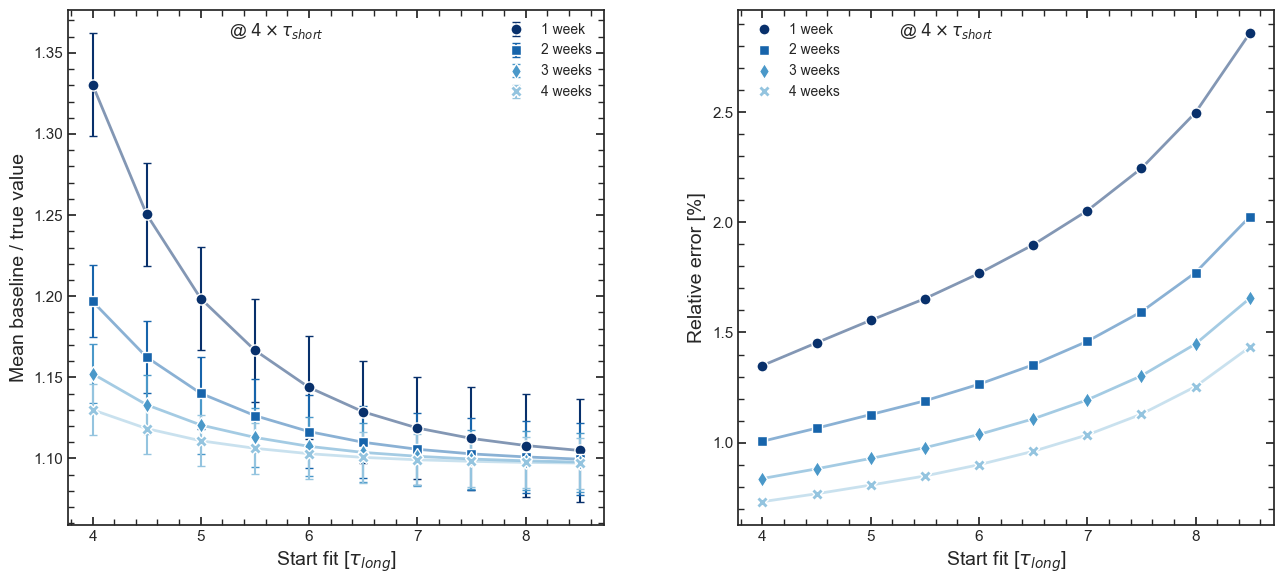

In [162]:
cmap = mpl.cm.get_cmap('Blues_r',6)

fig, ax = plt.subplots(1,2, figsize = (13,6))

x = np.arange(4,9,0.5)

y1, s1, y2, s2, y3, s3, y4, s4 = [], [], [], [], [],[],[],[]

for i in range(0,10): 
    y1.append(np.mean(tree.bs_LL[:,i]/6.0290323)/4.)
    y2.append(np.mean(tree2.bs_LL[:,i]/6.0290323)/8.)
    y3.append(np.mean(tree3.bs_LL[:,i]/6.0290323)/12.)
    y4.append(np.mean(tree4.bs_LL[:,i]/6.0290323)/16.)

    s1.append(100*np.mean(tree.bs_LL_relerr[:,i] ))
    s2.append(100*np.mean(tree2.bs_LL_relerr[:,i]))
    s3.append(100*np.mean(tree3.bs_LL_relerr[:,i]))
    s4.append(100*np.mean(tree4.bs_LL_relerr[:,i]))
    
yerr1 = np.mean(tree.bs_LL_err[:,i])/ (6.0290323 * 4)
yerr2= np.mean(tree2.bs_LL_err[:,i])/ (6.0290323 * 8)
yerr3= np.mean(tree3.bs_LL_err[:,i])/ (6.0290323 * 12)
yerr4= np.mean(tree4.bs_LL_err[:,i])/ (6.0290323 * 16)

ax[0].errorbar(taulong,y1,yerr = yerr1,  marker = 'o', mec = 'white', c = cmap(0), markersize = 8, ls = 'none',label = '1 week', capsize = 3)
ax[0].errorbar(taulong,y2, yerr = yerr2, marker = 's', mec = 'white', c = cmap(1), markersize = 7, ls = 'none',label = '2 weeks',  capsize = 3)
ax[0].errorbar(taulong,y3, yerr = yerr3, marker = 'd', mec = 'white', c = cmap(2), markersize = 8, ls = 'none',label = '3 weeks',  capsize = 3)
ax[0].errorbar(taulong,y4, yerr = yerr4, marker = 'X', mec = 'white', c = cmap(3), markersize = 8, ls = 'none',label = '4 weeks',  capsize = 3)


ax[0].plot(taulong,y1,  ls = '-',c = cmap(0),  alpha = 0.5, lw = 2  )
ax[0].plot(taulong,y2, ls = '-', c = cmap(1), alpha = 0.5 , lw = 2 )
ax[0].plot(taulong,y3, ls = '-', c = cmap(2), alpha = 0.5 , lw = 2 )
ax[0].plot(taulong,y4, ls = '-', c = cmap(3), alpha = 0.5 , lw = 2 )

ax[1].plot(taulong,s1,  ls = '-',c = cmap(0),  alpha = 0.5, lw = 2  )
ax[1].plot(taulong,s2, ls = '-', c = cmap(1), alpha = 0.5 , lw = 2 )
ax[1].plot(taulong,s3, ls = '-', c = cmap(2), alpha = 0.5 , lw = 2 )
ax[1].plot(taulong,s4, ls = '-', c = cmap(3), alpha = 0.5 , lw = 2 )

ax[1].plot(taulong,s1,  marker = 'o', c = cmap(0), markersize =8, mec = 'white', ls = 'none',label = '1 week')
ax[1].plot(taulong,s2, marker = 's', c = cmap(1), markersize = 7, mec = 'white', ls = 'none',label = '2 weeks')
ax[1].plot(taulong,s3, marker = 'd', c = cmap(2), markersize = 8, mec = 'white', ls = 'none',label = '3 weeks')
ax[1].plot(taulong,s4, marker = 'X', c = cmap(3), markersize = 8, mec = 'white', ls = 'none',label = '4 weeks')


ax[0].legend(loc='best', frameon=False, fontsize=10)
ax[1].legend(loc='best', frameon=False, fontsize=10)

ax[0].set_xlabel('Start fit [$\\tau_{long}$]', fontsize=14)
ax[0].set_ylabel('Mean baseline / true value', fontsize=14)

ax[1].set_xlabel('Start fit [$\\tau_{long}$]', fontsize=14)
ax[1].set_ylabel('Relative error [%]', fontsize=14)

ax[0].text(0.3,0.95,'@ $4 \\times \\tau_{short}$', transform = ax[0].transAxes)
ax[1].text(0.3,0.95,'@ $4 \\times \\tau_{short}$', transform = ax[1].transAxes)

fig.tight_layout()
fig.subplots_adjust( wspace = 0.25 )

fig.savefig("./plots/taulong_baseline.pdf")
plt.show()

In [203]:
tree4 = NanoEventsFactory.from_root('root_files/exp_base_v2.root', schemaclass = BaseSchema, treepath='baseline_exp_4').events()
tree5 = NanoEventsFactory.from_root('root_files/exp_base_v2.root', schemaclass = BaseSchema, treepath='baseline_exp_5').events()
tree6 = NanoEventsFactory.from_root('root_files/exp_base_v2.root', schemaclass = BaseSchema, treepath='baseline_exp_6').events()
tree7 = NanoEventsFactory.from_root('root_files/exp_base_v2.root', schemaclass = BaseSchema, treepath='baseline_exp_7').events()
tree8 = NanoEventsFactory.from_root('root_files/exp_base_v2.root', schemaclass = BaseSchema, treepath='baseline_exp_8').events()
tree9 = NanoEventsFactory.from_root('root_files/exp_base_v2.root', schemaclass = BaseSchema, treepath='baseline_exp_9').events()

In [204]:
matrix = np.zeros((6,10))

for i in range(0,10):
    matrix[0,i] = np.mean(tree4.tau_LL[:,i])
    matrix[1,i] = np.mean(tree5.tau_LL[:,i])
    matrix[2,i] = np.mean(tree6.tau_LL[:,i])
    matrix[3,i] = np.mean(tree7.tau_LL[:,i])
    matrix[4,i] = np.mean(tree8.tau_LL[:,i])
    matrix[5,i] = np.mean(tree9.tau_LL[:,i])

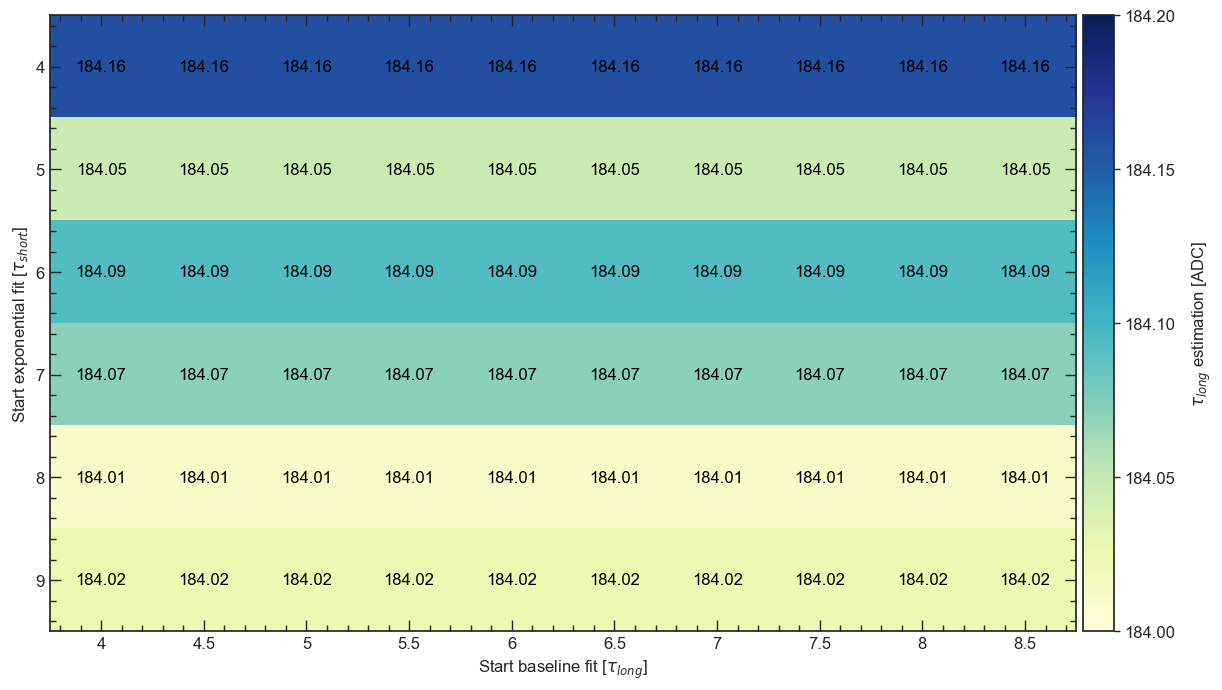

In [205]:
fig, ax = plt.subplots(figsize= (18,8))

im = ax.imshow(matrix, cmap='YlGnBu',vmax = 184.2, vmin = 184.)

# Show all ticks and label them with the respective list entries
labelsx = ['4','4.5','5','5.5','6','6.5','7','7.5','8','8.5']
labelsy = ['4','5','6','7','8','9']

ax.set_xticks(np.arange(len(labelsx)), labels=labelsx)
ax.set_yticks(np.arange(len(labelsy)), labels=labelsy)


# Loop over data dimensions and create text annotations.
for i in range(len(labelsy)):
    for j in range(len(labelsx)):
        text = ax.text(j, i, '%1.2f'%matrix[i, j],
                       ha="center", va="center", color="black")

ax.set_xlabel('Start baseline fit [$\\tau_{long}$]', fontsize = 12)
ax.set_ylabel('Start exponential fit [$\\tau_{short}$]', fontsize = 12)

ax.tick_params(which='major', width=1.0, length=8, direction='in', labelsize=12)

cb = fig.colorbar(im, ticks=c, ax = ax, pad = 0.005)
cb.set_label(label = '$\\tau_{long}$ estimation [ADC]', fontsize = 12, labelpad=10)
cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)
cb.ax.set_yticks(np.arange(184,184.21,0.05))

plt.show()


In [206]:
matrix = np.zeros((6,10))

for i in range(0,10):
    matrix[0,i] = np.mean(tree4.tau_LL_err[:,i]/tree4.tau_LL[:,i])
    matrix[1,i] = np.mean(tree5.tau_LL_err[:,i]/tree5.tau_LL[:,i])
    matrix[2,i] = np.mean(tree6.tau_LL_err[:,i]/tree6.tau_LL[:,i])
    matrix[3,i] = np.mean(tree7.tau_LL_err[:,i]/tree7.tau_LL[:,i])
    matrix[4,i] = np.mean(tree8.tau_LL_err[:,i]/tree8.tau_LL[:,i])
    matrix[5,i] = np.mean(tree9.tau_LL_err[:,i]/tree9.tau_LL[:,i])

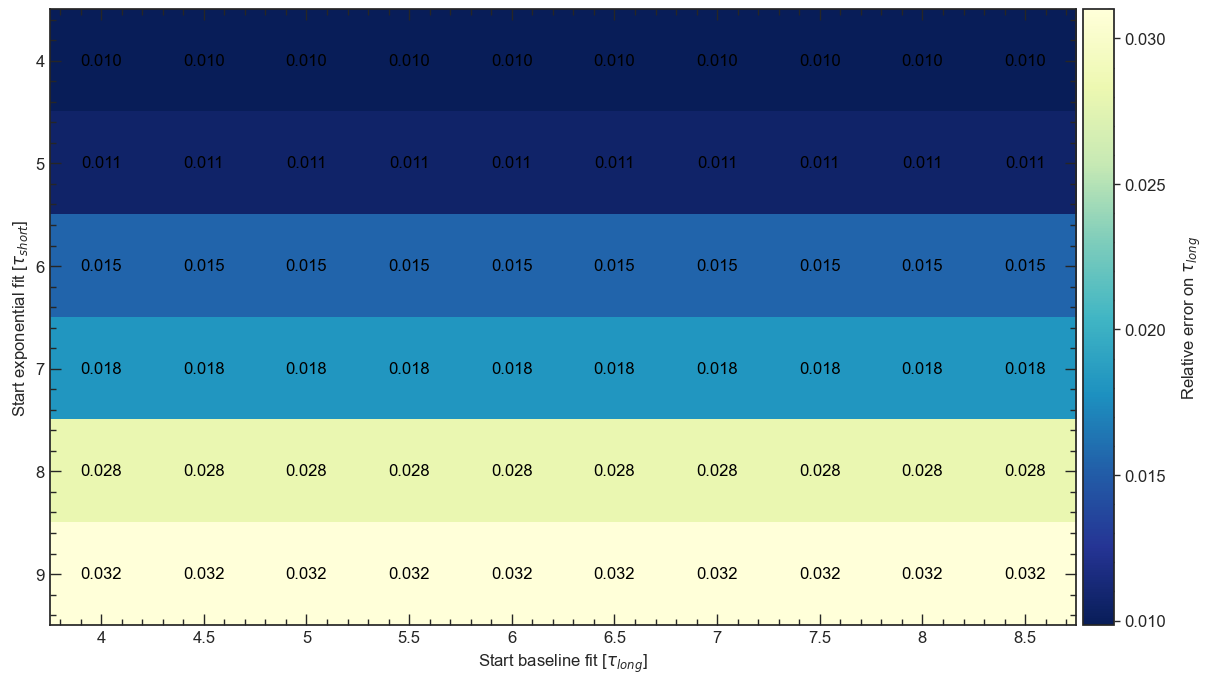

In [207]:
fig, ax = plt.subplots(figsize= (18,8))

im = ax.imshow(matrix, cmap='YlGnBu_r', vmax = 0.031)

# Show all ticks and label them with the respective list entries
labelsx = ['4','4.5','5','5.5','6','6.5','7','7.5','8','8.5']
labelsy = ['4','5','6','7','8','9']


ax.set_xticks(np.arange(len(labelsx)), labels=labelsx)
ax.set_yticks(np.arange(len(labelsy)), labels=labelsy)


# Loop over data dimensions and create text annotations.
for i in range(len(labelsy)):
    for j in range(len(labelsx)):
        text = ax.text(j, i, '%1.3f'%matrix[i, j],
                       ha="center", va="center", color="black")

ax.set_xlabel('Start baseline fit [$\\tau_{long}$]', fontsize = 12)
ax.set_ylabel('Start exponential fit [$\\tau_{short}$]', fontsize = 12)

ax.tick_params(which='major', width=1.0, length=8, direction='in', labelsize=12)

cb = fig.colorbar(im, ticks=c, ax = ax, pad = 0.005)
cb.set_label(label = 'Relative error on $\\tau_{long}$', fontsize = 12, labelpad=10)
cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)
cb.ax.set_yticks(np.arange(0.01,0.031,0.005))

plt.show()



In [177]:
## one week 

for i in range(4,10):
    globals()[f'tree{i}'] = NanoEventsFactory.from_root('root_files/exp_base_v2.root', schemaclass = BaseSchema, treepath='baseline_exp_%i'%i).events()

## two weeks 

for i in range(4,10):
    globals()[f'tree{i}_2'] = NanoEventsFactory.from_root('root_files/exp_base_v2_2.root', schemaclass = BaseSchema, treepath='baseline_exp_%i'%i).events()

## three weeks 

for i in range(4,10):
    globals()[f'tree{i}_3'] = NanoEventsFactory.from_root('root_files/exp_base_v2_3.root', schemaclass = BaseSchema, treepath='baseline_exp_%i'%i).events()

## four weeks 

for i in range(4,10):
    globals()[f'tree{i}_4'] = NanoEventsFactory.from_root('root_files/exp_base_v2_4.root', schemaclass = BaseSchema, treepath='baseline_exp_%i'%i).events()



In [191]:
## one week 
tau1, tau2, tau3, tau4 = [],[],[],[]

for i in range(4,10):
    tau1.append(np.mean(locals()[f'tree{i}'].tau_LL[:,7][100:]))
    tau2.append(np.mean(locals()[f'tree{i}_2'].tau_LL[:,7][1000:]))
    tau3.append(np.mean(locals()[f'tree{i}_3'].tau_LL[:,7][1000:]))
    tau4.append(np.mean(locals()[f'tree{i}_4'].tau_LL[:,7][1000:]))
